In [2]:
import pandas as pd
import glob
import os
import scipy
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
import re

In [ ]:
path = os.path.expanduser('~/illusory-occlusion/online/experiment2/data')
datapath = glob.glob(path + '/*.csv')

## Very general analysis of csv

In [ ]:
df = [pd.read_csv(doc) for doc in datapath]
big_df = pd.concat(df, ignore_index=True)

# save the big dataframe
big_df.to_csv(path + '/big_df.csv', index=False)

C:\Users\90957667\AppData\Local\Temp\ipykernel_19592\2531616942.py:1: DtypeWarning: Columns (32,33,34,35,36,40,64,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  df = [pd.read_csv(doc) for doc in datapath]


In [187]:
print(len(df))

complete_datasets = []
for f in datapath:
    data = pd.read_csv(f)
    if len(data) == 1465:
        complete_datasets.append(data)

print(len(complete_datasets))

113


C:\Users\90957667\AppData\Local\Temp\ipykernel_19592\601354776.py:5: DtypeWarning: Columns (32,33,34,35,36,40,64,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f)


61


In [6]:
print(big_df.columns)
print(pd.unique(big_df['test_part']))
print(pd.unique(big_df['trialnr']))

Index(['Unnamed: 0', 'means_acc_behval', 'means_acc_behinval',
       'means_acc_frval', 'means_acc_frinval', 'means_rt_behval',
       'means_rt_behinval', 'means_rt_frval', 'means_rt_frinval',
       'diff_acc_validity_behind', 'diff_acc_validity_front',
       'diff_acc_position_valid', 'diff_acc_position_invalid',
       'diff_rt_position_valid', 'diff_rt_position_invalid',
       'diff_rt_validity_behind', 'diff_rt_validity_front',
       'performance_index_behval', 'performance_index_behinval',
       'performance_index_frval', 'performance_index_frinval',
       'performance_validity_behind', 'diff_performance_index_front',
       'control_performance', 'trial_type', 'trial_index', 'time_elapsed',
       'internal_node_id', 'success', 'timeout', 'failed_images',
       'failed_audio', 'failed_video', 'rt', 'stimulus', 'response',
       'surveyCode', 'test_part', 'final_height_px', 'final_width_px',
       'scale_factor', 'value', 'trialnr', 'obj', 'stim', 'task', 'acc_behval',


## Unify csv and correct counterbalance
* 'biological': 1 is bio; 0 is nonbio
* 'behind': 0 front; 1 behind
* 'valid': 1 valid; 0 invalid
* 'cresp': response code ('z' or 'm')
* 'mean_correct': mean of the correct responses of each stimulus
* 'zrt': standarised rt

In [4]:
alldata = pd.DataFrame()
pattern1 = r'stimuli/(\d+)_(\w+)_(\w+)(\d)_(\w+)_(\w+)_(\w+).png'
pattern2 = r'obj_words/(\w+).png'

s=0
c = []
for f in datapath:
    data = pd.read_csv(f)
    if len(data)==1465: #only keep full datasets
        clean_data = data.dropna(subset=['stim', 'obj'])
        #data = data[data['test_part'].isin(['stim', 'response'])]
        clean_data = clean_data[clean_data['test_part']=='response']
        s = s+1
        clean_data['subjectnr'] = [s for _ in clean_data['stim']]
        clean_data['biological'] = [int('bio_' in x) for x in clean_data['stim']]
        clean_data['behind'] = ['occluded' if '_behind_' in x else 'not occluded' for x in clean_data['stim']]
        clean_data['valid'] = ['valid' if '_valid' in x else 'invalid' for x in clean_data['stim']]
        
        
        for idx, row in clean_data.iterrows():
            stim_path = row['stim']
            obj_path = row['obj']
            task = row['task']  
            
            match1 = re.match(pattern1, stim_path)
            match2 = re.match(pattern2, obj_path)

            if match1 and match2:
                group_from_pattern1 = match1.group(3)
                group_from_pattern2 = match2.group(1)

                if group_from_pattern1 == group_from_pattern2:
                    if '[z] same' in task:
                        c.append('z')
                    elif '[z] different' in task:
                        c.append('m') 

                else:       
                    if '[z] same' in task:
                        c.append('m')
                    elif '[z] different' in task:
                        c.append('z')

        clean_data['zrt'] = scipy.stats.zscore(clean_data['rt'])
        alldata = pd.concat((alldata,clean_data))

alldata['cresp'] = c
alldata['correct'] = [int(x==y) for x,y in zip(alldata['response'],alldata['cresp'])]
        
        
print(alldata)
with open('responses.csv','w') as out:
    alldata.to_csv(out,index_label='index')

C:\Users\90957667\AppData\Local\Temp\ipykernel_9760\2607731463.py:8: DtypeWarning: Columns (32,33,34,35,36,40,64,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f)


                  trial_type  trial_index  time_elapsed internal_node_id  \
24    html-keyboard-response           24        132869         0.0-24.0   
28    html-keyboard-response           28        136291         0.0-28.0   
32    html-keyboard-response           32        139247         0.0-32.0   
36    html-keyboard-response           36        141903         0.0-36.0   
40    html-keyboard-response           40        144643         0.0-40.0   
...                      ...          ...           ...              ...   
1447  html-keyboard-response         1447       2156998       0.0-1447.0   
1451  html-keyboard-response         1451       2159578       0.0-1451.0   
1455  html-keyboard-response         1455       2162257       0.0-1455.0   
1459  html-keyboard-response         1459       2164765       0.0-1459.0   
1463  html-keyboard-response         1463       2167529       0.0-1463.0   

     success timeout failed_images failed_audio failed_video      rt  ...  \
24       N

## Exploratory data analysis

In [ ]:
responses_path = f'{path}/responses.csv'

Responses = pd.read_csv(responses_path)

#### Demographic

In [6]:
import json

demographic = []
for f in datapath:
    data = pd.read_csv(f)
    if len(data)==1465: #only keep full datasets
        demographic.append(data[data['trial_type']=='survey-html-form'])
demographic = pd.concat(demographic, ignore_index=True)

ages = []
gender = []
handendess = []
for dem in demographic['response']:
    dem_dict = json.loads(dem)
    if 'age' in dem_dict:
        try:
            ages.append(float(dem_dict['age']))
        except ValueError:
            pass
    if 'gender' in dem_dict:
        gender.append(dem_dict['gender'])
    if 'handedness' in dem_dict:
        handendess.append(dem_dict['handedness'])
    

print(pd.Series(ages).describe())
print("Genders:", pd.Series(gender).unique(), pd.Series(gender).value_counts())
print("Handendess", pd.Series(handendess).unique(), pd.Series(handendess).value_counts())

C:\Users\90957667\AppData\Local\Temp\ipykernel_9760\521983695.py:5: DtypeWarning: Columns (32,33,34,35,36,40,64,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f)


count    61.000000
mean     30.836066
std      12.186304
min      18.000000
25%      21.000000
50%      26.000000
75%      41.000000
max      61.000000
dtype: float64
Genders: ['female' 'nb' 'male'] female    37
male      22
nb         2
Name: count, dtype: int64
Handendess ['right' 'left'] right    56
left      5
Name: count, dtype: int64


#### Mean accuracy and rt within subjects

Separate analysis for accuracy and rt

Accuracy:
+ mean
+ trim participants with accuracy rate below 60%

RT:
+ only for correct responses
+ median
+ trim participants with mean RT > 1 second


##### Accuracy

In [ ]:
subjectnr = np.unique(Responses['subjectnr'])

acc_behval = []
acc_behinval = []
acc_frval = []
acc_frinval = []

for s in subjectnr:
    sacc_behval = []
    sacc_behinval = []
    sacc_frval = []
    sacc_frinval = []

    for i in range(len(Responses['subjectnr'])):
            if Responses['subjectnr'][i] == s:
                x = Responses['stim'][i]
                if 'behind_valid' in x:
                    sacc_behval.append(Responses['correct'][i])
                elif 'behind_invalid' in x:
                    sacc_behinval.append(Responses['correct'][i])
                elif 'front_valid' in x:
                    sacc_frval.append(Responses['correct'][i])
                elif 'front_invalid' in x:
                    sacc_frinval.append(Responses['correct'][i])
    
    acc_behval.append(sacc_behval)
    acc_behinval.append(sacc_behinval)
    acc_frval.append(sacc_frval)
    acc_frinval.append(sacc_frinval)

In [ ]:
Avg_raw = pd.DataFrame()
Avg_raw['means_acc_behval'] = np.mean(np.array(acc_behval), axis=1)
Avg_raw['means_acc_behinval'] = np.mean(np.array(acc_behinval), axis=1)
Avg_raw['means_acc_frval'] = np.mean(np.array(acc_frval), axis=1)
Avg_raw['means_acc_frinval'] = np.mean(np.array(acc_frinval), axis=1)
Avg_raw['diff_acc_validity_behind'] = Avg_raw['means_acc_behval'] - Avg_raw['means_acc_behinval']
Avg_raw['diff_acc_validity_front'] = Avg_raw['means_acc_frval'] - Avg_raw['means_acc_frinval']

with open('averages_accuracy.csv','w') as out:
    Avg_raw.to_csv(out,index_label='index')

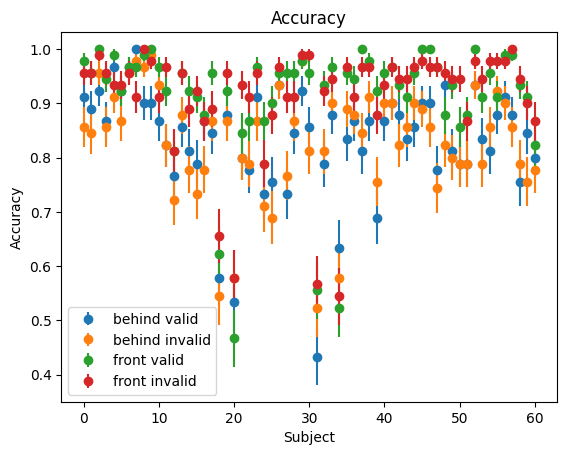

In [ ]:
# Calculate standard deviation
Std = pd.DataFrame()
Std['std_acc_behval'] = np.std(np.array(acc_behval), axis=1)
Std['std_acc_behinval'] = np.std(np.array(acc_behinval), axis=1)
Std['std_acc_frval'] = np.std(np.array(acc_frval), axis=1)
Std['std_acc_frinval'] = np.std(np.array(acc_frinval), axis=1)

with open('std_conditions.csv','w') as out:
    Std.to_csv(out,index_label='index')

# Calculate standard error
SE = pd.DataFrame()
SE['se_acc_behval'] = np.std(np.array(acc_behval), axis=1)/np.sqrt(len(acc_behval[0]))
SE['se_acc_behinval'] = np.std(np.array(acc_behinval), axis=1)/np.sqrt(len(acc_behinval[0]))
SE['se_acc_frval'] = np.std(np.array(acc_frval), axis=1)/np.sqrt(len(acc_behinval[0]))
SE['se_acc_frinval'] = np.std(np.array(acc_frinval), axis=1)/np.sqrt(len(acc_behinval[0]))
with open('se_conditions.csv','w') as out:
    SE.to_csv(out,index_label='index')

# Plotting SE
plt.figure()
plt.errorbar(range(len(acc_behval)), Avg_raw['means_acc_behval'], yerr=SE['se_acc_behval'], fmt='o', label='behind valid')
plt.errorbar(range(len(acc_behinval)), Avg_raw['means_acc_behinval'], yerr=SE['se_acc_behinval'], fmt='o', label='behind invalid')
plt.errorbar(range(len(acc_frval)), Avg_raw['means_acc_frval'], yerr=SE['se_acc_frval'], fmt='o', label='front valid')
plt.errorbar(range(len(acc_frinval)), Avg_raw['means_acc_frinval'], yerr=SE['se_acc_frinval'], fmt='o', label='front invalid')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Subject')
plt.ylabel('Accuracy')
plt.show()


#### Trimming data

In [ ]:
# Step 1: Calculate mean and standard deviation for each variable
means = Avg_raw.mean()
stds = Avg_raw.std()

# Step 2: Define the outlier range
lower_bounds = means - 2.5 * stds
print('lower bound:', lower_bounds)

# Step 3: Identify outliers
outliers = pd.DataFrame()

for col in Avg_raw.columns:
    outliers[f'outlier_{col}'] = (Avg_raw[col] < lower_bounds[col]) 

# Step 4: Add outlier flags to the original DataFrame
Avg_outliers = Avg_raw.join(outliers)

# Display participants who are outliers for at least one variable
outlier_participants = Avg_outliers[outliers.any(axis=1)]


lower bound: means_acc_behval            0.580716
means_acc_behinval          0.575713
means_acc_frval             0.638815
means_acc_frinval           0.669773
diff_acc_validity_behind   -0.110022
diff_acc_validity_front    -0.096806
dtype: float64


In [ ]:
data_accuracy = []

conditions = ['behval', 'behinval', 'frval', 'frinval']
outliers = [16, 19, 21, 32, 35, 56] #from accuracy and rt outliers

for s in subjectnr:
    if s not in outliers:
        for c in conditions:
            avg_dict = {'sub': s}
            
            if c == 'behval':
                acc_mean = np.mean(np.array(acc_behval)[s-1])
                
                avg_dict['validity'] = 1
                avg_dict['occlusion'] = 1
                avg_dict['accuracy'] = acc_mean
                
            
            elif c == 'behinval':
                acc_mean = np.mean(np.array(acc_behinval)[s-1])
                
                avg_dict['validity'] = 0
                avg_dict['occlusion'] = 1
                avg_dict['accuracy'] = acc_mean
                
            
            elif c == 'frval':
                acc_mean = np.mean(np.array(acc_frval)[s-1])
                
                avg_dict['validity'] = 1
                avg_dict['occlusion'] = 0
                avg_dict['accuracy'] = acc_mean
                

            elif c == 'frinval':
                acc_mean = np.mean(np.array(acc_frinval)[s-1])
                
                avg_dict['validity'] = 0
                avg_dict['occlusion'] = 0
                avg_dict['accuracy'] = acc_mean
                

            data_accuracy.append(avg_dict)

Avg = pd.DataFrame(data_accuracy)

with open('averages_accuracy.csv','w') as out:
    Avg.to_csv(out,index_label='index')



In [ ]:
Avg['occlusion'] = Avg['occlusion'].astype(str)

occluded_condition = '1'
#include only the occluded condition
Avg_occluded = Avg[Avg['occlusion'] == occluded_condition]

In [46]:
Avg['validity'] = Avg['validity'].astype(str) 
Avg_occluded['validity'] = Avg_occluded['validity'].map({'1': 'valid', '0': 'invalid'})

C:\Users\90957667\AppData\Local\Temp\ipykernel_1624\469881965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Avg_occluded['validity'] = Avg_occluded['validity'].map({'1': 'valid', '0': 'invalid'})


C:\Users\90957667\AppData\Local\Temp\ipykernel_1624\1866403319.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Avg_occluded['validity'] = Avg_occluded['validity'].astype(str)
C:\Users\90957667\AppData\Local\Temp\ipykernel_1624\1866403319.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Avg_occluded['validity'] = Avg_occluded['validity'].map({'1': 'valid', '0': 'invalid'})


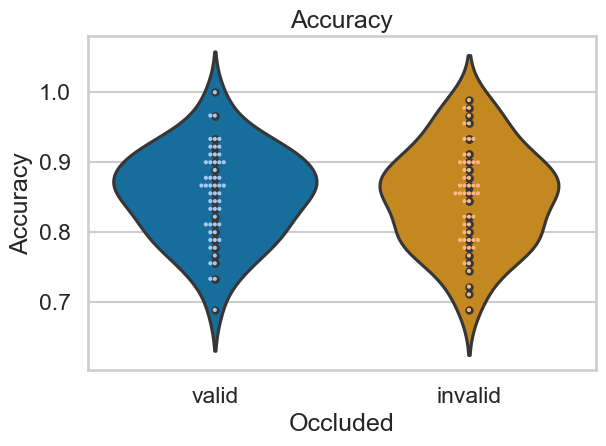

In [47]:
# Plotting without occlusion condition
Avg['occlusion'] = Avg['occlusion'].astype(str)

occluded_condition = '1'
Avg_occluded = Avg[Avg['occlusion'] == occluded_condition]

Avg_occluded['validity'] = Avg_occluded['validity'].astype(str) 
Avg_occluded['validity'] = Avg_occluded['validity'].map({'1': 'valid', '0': 'invalid'})


sns.set(style="whitegrid")
sns.set_context("talk")
fig, ax = plt.subplots()

violin_palette = {"valid": "#00c6ab", "invalid": "#c600c6"} #invalid = 0, valid=1
swarm_palette = {"valid": "#03ffef", "invalid": "#ff6dff"}

#accuracy
sns.violinplot(x='validity', y='accuracy',data=Avg_occluded, ax=ax,
               inner='point', dodge=True, palette='colorblind')  #Changed colour to palette
sns.swarmplot(x='validity', y='accuracy',data=Avg_occluded, ax=ax, 
              dodge=True, palette='pastel', edgecolor='gray', size=3)  #changed colour to palette

ax.set_title('Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Occluded')


plt.tight_layout()
plt.show()

##### Reaction Times

In [21]:
rt_behval = []
rt_behinval = []
rt_frval = []
rt_frinval = []


for s in subjectnr:
    srt_behval = []
    srt_behinval = []
    srt_frval = []
    srt_frinval = []

    for i in range(len(Responses['subjectnr'])):
            if Responses['subjectnr'][i] == s:
                if Responses['correct'][i] == 1:
                    x = Responses['stim'][i]
                    if 'behind_valid' in x:
                        srt_behval.append(Responses['rt'][i])
                    elif 'behind_invalid' in x:
                        srt_behinval.append(Responses['rt'][i])
                    elif 'front_valid' in x:
                        srt_frval.append(Responses['rt'][i])
                    elif 'front_invalid' in x:
                        srt_frinval.append(Responses['rt'][i])
                
    rt_behval.append(srt_behval)
    rt_behinval.append(srt_behinval)
    rt_frval.append(srt_frval)
    rt_frinval.append(srt_frinval)

In [33]:
Rt = pd.DataFrame()
Rt['mdn_rt_behval'] = [np.median(x) for x in rt_behval] 
Rt['mdn_rt_behinval'] = [np.median(x) for x in rt_behinval]
Rt['mdn_rt_frval'] = [np.median(x) for x in rt_frval]
Rt['mdn_rt_frinval'] = [np.median(x) for x in rt_frinval]

Rt['diff_rt_validity_behind'] = Rt['mdn_rt_behval'] - Rt['mdn_rt_behinval']
Rt['diff_rt_validity_front'] = Rt['mdn_rt_frval'] - Rt['mdn_rt_frinval']

with open('averages_rt.csv','w') as out:
    Rt.to_csv(out,index_label='index')

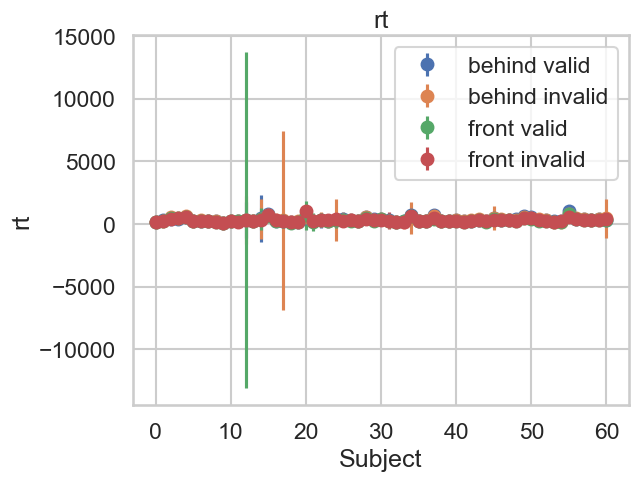

In [ ]:
# Calculate standard deviation
Std_rt = pd.DataFrame()
Std_rt['std_rt_behval'] = [np.std(x) for x in rt_behval]  # Compute std per participant
Std_rt['std_rt_behinval'] = [np.std(x) for x in rt_behinval]
Std_rt['std_rt_frval'] = [np.std(x) for x in rt_frval]
Std_rt['std_rt_frinval'] = [np.std(x) for x in rt_frinval]

with open('std_rt.csv','w') as out:
    Std_rt.to_csv(out,index_label='index')

# Calculate standard error-> Standard Error = (Standard Deviation) / sqrt(N)
SE_rt = pd.DataFrame()
SE_rt['se_rt_behval'] = [
    np.std(rt_list) / np.sqrt(len(rt_list))  
    for rt_list in rt_behval
]
SE_rt['se_rt_behinval'] = [
    np.std(rt_list) / np.sqrt(len(rt_list))
    for rt_list in rt_behinval
]
SE_rt['se_rt_frval'] = [
    np.std(rt_list) / np.sqrt(len(rt_list))
    for rt_list in rt_frval
]
SE_rt['se_rt_frinval'] = [
    np.std(rt_list) / np.sqrt(len(rt_list))
    for rt_list in rt_frinval
]
with open('se_rt.csv','w') as out:
    SE_rt.to_csv(out,index_label='index')

# Plotting SE
plt.figure()
plt.errorbar(range(len(rt_behval)), Rt['mdn_rt_behval'], yerr=SE_rt['se_rt_behval'], fmt='o', label='behind valid')
plt.errorbar(range(len(rt_behinval)), Rt['mdn_rt_behinval'], yerr=SE_rt['se_rt_behinval'], fmt='o', label='behind invalid')
plt.errorbar(range(len(rt_frval)), Rt['mdn_rt_frval'], yerr=SE_rt['se_rt_frval'], fmt='o', label='front valid')
plt.errorbar(range(len(rt_frinval)), Rt['mdn_rt_frinval'], yerr=SE_rt['se_rt_frinval'], fmt='o', label='front invalid')
plt.legend()
plt.title('rt')
plt.xlabel('Subject')
plt.ylabel('rt')
plt.show()

## plot

In [48]:

data_re = []

conditions = ['behval', 'behinval', 'frval', 'frinval']
outliers = [16, 19, 21, 32, 35, 56] #from accuracy and rt outliers

for s in subjectnr:
    if s not in outliers:
        for c in conditions:
            rt_dict = {'sub': s}
    
            if c == 'behval':
                rt_median = np.median(rt_behval[s-1])
                rt_std = np.std(rt_behval[s-1])
                rt_se = rt_std/np.sqrt(len(rt_behval[s-1]))
                rt_dict['validity'] = 1
                rt_dict['occlusion'] = 1
                rt_dict['rt_median'] = rt_median
                rt_dict['rt_std'] = rt_std
                rt_dict['rt_se'] = rt_se
    
                
            elif c == 'behinval':
                rt_median = np.median(rt_behinval[s-1])
                rt_std = np.std(rt_behinval[s-1])
                rt_se = rt_std/np.sqrt(len(rt_behinval[s-1]))
                rt_dict['validity'] = 0
                rt_dict['occlusion'] = 1
                rt_dict['rt_median'] = rt_median
                rt_dict['rt_std'] = rt_std
                rt_dict['rt_se'] = rt_se
    
            elif c == 'frval':
                rt_median = np.median(rt_frval[s-1])
                rt_std = np.std(rt_frval[s-1])
                rt_se = rt_std/np.sqrt(len(rt_frval[s-1]))
                rt_dict['validity'] = 1
                rt_dict['occlusion'] = 0
                rt_dict['rt_median'] = rt_median
                rt_dict['rt_std'] = rt_std
                rt_dict['rt_se'] = rt_se
    
            elif c == 'frinval':
                rt_median = np.median(rt_frinval[s-1])
                rt_std = np.std(rt_frinval[s-1])
                rt_se = rt_std/np.sqrt(len(rt_frinval[s-1]))
                rt_dict['validity'] = 0
                rt_dict['occlusion'] = 0
                rt_dict['rt_median'] = rt_median
                rt_dict['rt_std'] = rt_std
                rt_dict['rt_se'] = rt_se
            
            data_re.append(rt_dict)


Rt = pd.DataFrame(data_re)

with open('clean_rt.csv','w') as out:
    Rt.to_csv(out,index_label='index')




C:\Users\90957667\AppData\Local\Temp\ipykernel_1624\2577383644.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Rt_occluded['validity'] = Rt_occluded['validity'].astype(str)
C:\Users\90957667\AppData\Local\Temp\ipykernel_1624\2577383644.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Rt_occluded['validity'] = Rt_occluded['validity'].map({'1': 'valid', '0': 'invalid'})


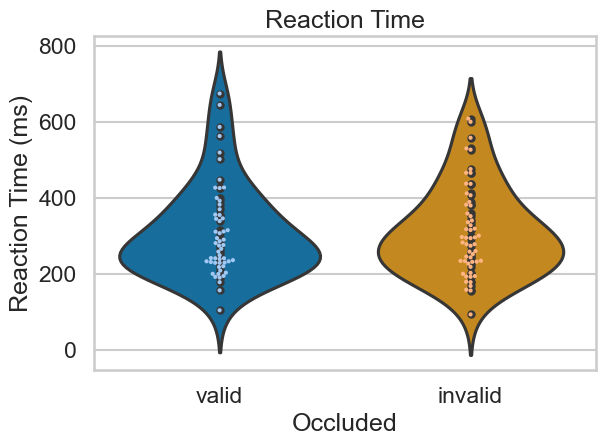

In [49]:
# Plotting without occlusion condition
Rt['occlusion'] = Rt['occlusion'].astype(str)

occluded_condition = '1'
Rt_occluded = Rt[Rt['occlusion'] == occluded_condition]


Rt_occluded['validity'] = Rt_occluded['validity'].astype(str)
Rt_occluded['validity'] = Rt_occluded['validity'].map({'1': 'valid', '0': 'invalid'})

sns.set(style="whitegrid")
sns.set_context("talk")
fig, ax = plt.subplots()

violin_palette = {"valid": "#00c6ab", "invalid": "#c600c6"} #invalid = 0, valid=1
swarm_palette = {"valid": "#03ffef", "invalid": "#ff6dff"}


#reaction times
sns.violinplot(x='validity', y='rt_median', data=Rt_occluded, ax=ax, 
               inner='point', dodge=True, palette='colorblind')  
sns.swarmplot(x='validity', y='rt_median', data=Rt_occluded, ax=ax, 
              dodge=True, palette='pastel', edgecolor='gray', size=3)  

ax.set_title('Reaction Time')
ax.set_ylabel('Reaction Time (ms)')
ax.set_xlabel('Occluded')


plt.tight_layout()
plt.show()